In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from scipy import io
from typing import Dict
from typing import NamedTuple
from typing_extensions import override
import numpy as np
from abc import ABC, abstractmethod
import time

from lib.preprocess import preprocess_image, training_validation_split
from lib.load import load_mnist, load_spam
from lib.train import compare_single_vs_multi, train, classification_accuracy
from lib.train import mnist_pipeline_hyperparamter_tuning



# Evaluation metric

In [2]:



def mnist_pipeline() -> dict[str, dict[str, float]]:
    """
    Complete pipeline for loading, preprocessing, training, and evaluating MNIST models with different training sizes.

    Loads the MNIST dataset, preprocesses the images, splits into training and validation sets, trains models, and prints error rates for each training size.
    """
    # toy_mnist_spam = load_all_data_sets()
    mnist = load_mnist()
    mnist_training_data = mnist["training_data"]
    mnist_training_labels = mnist["training_labels"]
    model_training_size: Dict[str, svm.LinearSVC] = {}
    training_sizes = [100, 200, 500, 1_000, 2_000, 5_000, 10_000]
    error_rate: dict[str, dict[str, float]] = {}
    preprocess_mnist_training_data = preprocess_image(mnist_training_data)
    for training_size in training_sizes:
        model_name = "Model_Training_Size" + str(training_size)
        error_rate[model_name] = {}
        training_data, training_labels, validation_data, validation_labels = training_validation_split(training_size, preprocess_mnist_training_data, mnist_training_labels)
        trained_model = train(training_data, training_labels)
        model_training_size[model_name] = trained_model
        training_res = trained_model.predict(training_data)
        training_error =  classification_accuracy(training_res, training_labels)
        validation_res = trained_model.predict(validation_data)
        validation_error =  classification_accuracy(validation_res, validation_labels)
        error_rate[model_name]["training_error"] = training_error
        error_rate[model_name]["validation_error"] = validation_error
    return error_rate

In [3]:
# Train MNIST with different number of data: [100, 200, 500, 1,000, 2,000, 5,000, 10,000]
trainingSize = [100, 200, 500, 1_000, 2_000, 5_000, 10_000]
error_rate = mnist_pipeline()
size: list[int] = []
training_errors: list[float] = []
validation_errors: list[float] = []
for name, errors in error_rate.items():
    size.append(int(name.replace("Model_Training_Size", "")))
    validation_errors.append(errors["validation_error"])
    training_errors.append(errors["training_error"])
    


c:\Users\super_grool\anaconda3\envs\machinelearning\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\super_grool\anaconda3\envs\machinelearning\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


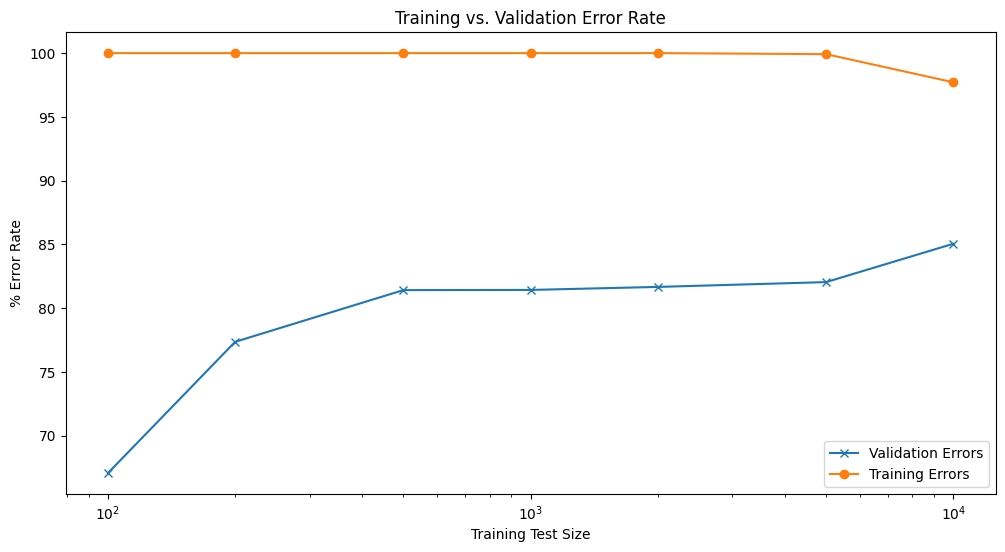

<Figure size 1200x600 with 0 Axes>

In [4]:
plt.figure(figsize=(12,6))
plt.plot(size, 100*np.array(validation_errors), label='Validation Errors',marker='x')
plt.plot(size, 100*np.array(training_errors), label='Training Errors', marker='o')
plt.xlabel("Training Test Size")
plt.ylabel("% Error Rate")
plt.title('Training vs. Validation Error Rate')
plt.xscale("log")
plt.legend()
plt.figure(figsize=(12,6))
plt.show()

In [5]:
def spam_pipeline() -> dict[str, dict[str, float]]:
    """
    Complete pipeline for loading, preprocessing, training, and evaluating spam models with different training sizes.
    Loads the Spam dataset, preprocesses the images, splits into training and validation sets, trains models, and prints error rates for each training size.
    """

    spam = load_spam()
    spam_training_data = spam["training_data"]
    spam_training_labels = spam["training_labels"]
    model_training_size: Dict[str, svm.LinearSVC] = {}
    training_sizes = [100, 200, 500, 1_000, 2_000, "ALL"]
    error_rate: dict[str, dict[str, float]] = {}
    for training_size in training_sizes:
        model_name = "Model_Training_Size" + str(training_size)
        error_rate[model_name] = {}
        training_data, training_labels, validation_data, validation_labels = training_validation_split(training_size, spam_training_data, spam_training_labels)        
        trained_model = train(training_data, training_labels)
        model_training_size[model_name] = trained_model
        training_res = trained_model.predict(training_data)
        training_error =  classification_accuracy(training_res, training_labels)
        if len(validation_data) > 0:
            validation_res = trained_model.predict(validation_data)
            validation_error =  classification_accuracy(validation_res, validation_labels)
            error_rate[model_name]["validation_error"] = validation_error
            error_rate[model_name]["training_error"] = training_error
        else:
            error_rate[model_name]["validation_error"] = np.nan
            error_rate[model_name]["training_error"] = training_error
    return error_rate, spam_training_data.shape[0]

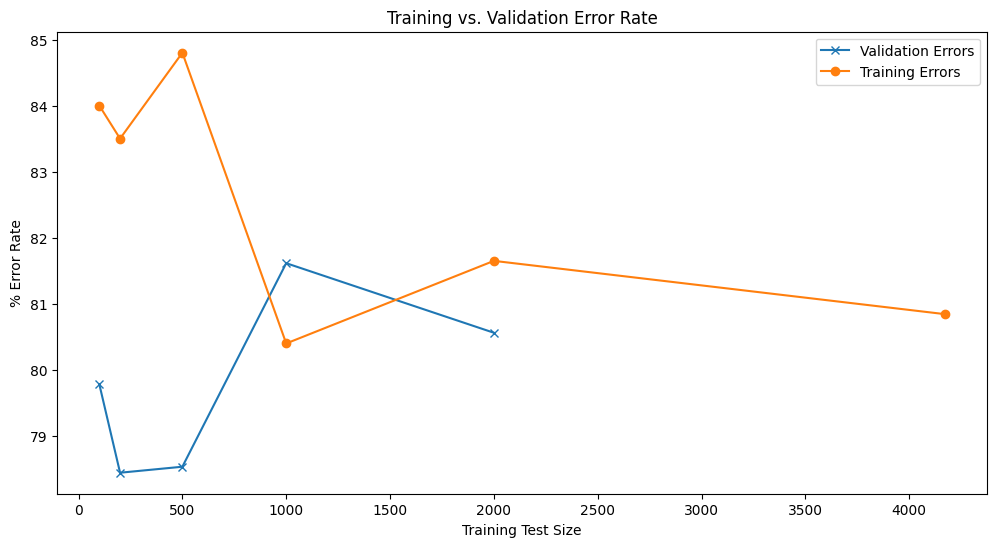

In [6]:
error_rate, size_of_all_training  = spam_pipeline()
trainingSize = [100, 200, 500, 1_000, 2_000, 5_000, "ALL"]
size: list[int] = []
training_errors_spam: list[float] = []
validation_errors_spam: list[float] = []
for name, errors in error_rate.items():
    if name.endswith('ALL'):
        size.append(size_of_all_training)
        validation_errors_spam.append(np.nan)
        training_errors_spam.append(errors["training_error"])
    else:
        size.append(int(name.replace("Model_Training_Size", "")))
        validation_errors_spam.append(errors["validation_error"])
        training_errors_spam.append(errors["training_error"])
plt.figure(figsize=(12,6))
plt.plot(size, 100*np.array(validation_errors_spam), label='Validation Errors',marker='x')
plt.plot(size, 100*np.array(training_errors_spam), label='Training Errors', marker='o')
plt.xlabel("Training Test Size")
plt.ylabel("% Error Rate")
plt.title('Training vs. Validation Error Rate')
plt.legend()
plt.show()

# Hyperparameter Tuning

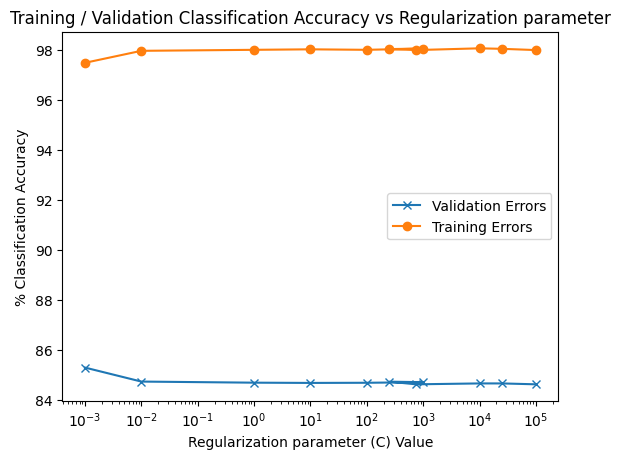

In [11]:
mnist = load_mnist()
C = [.001, .01, 1, 10, 100, 1000,250,750, 10000,25000, 100000, 100000]
regularization_parameter_tested = []
validation_errors = []
training_errors = []
error_rate_and_model = mnist_pipeline_hyperparamter_tuning(C, 10_000)
for c, errors in error_rate_and_model.items():
    regularization_parameter_tested.append(float(c))
    validation_errors.append(errors["validation_error"])
    training_errors.append(errors["training_error"])
plt.plot(regularization_parameter_tested, 100*np.array(validation_errors), label='Validation Errors',marker='x')
plt.plot(regularization_parameter_tested, 100*np.array(training_errors), label='Training Errors', marker='o')
plt.xlabel("Regularization parameter (C) Value")
plt.ylabel("% Classification Accuracy")
plt.title('Training / Validation Classification Accuracy vs Regularization parameter')
plt.legend()
plt.xscale("log")
plt.savefig("Regularization_parameter_optimization.jpeg")
plt.show()

# K-Fold Cross Validation

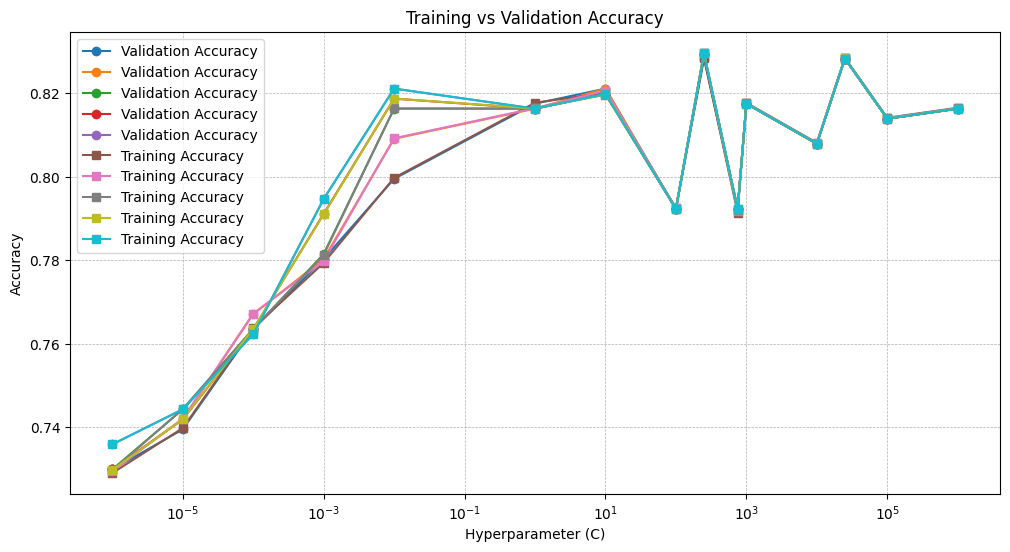

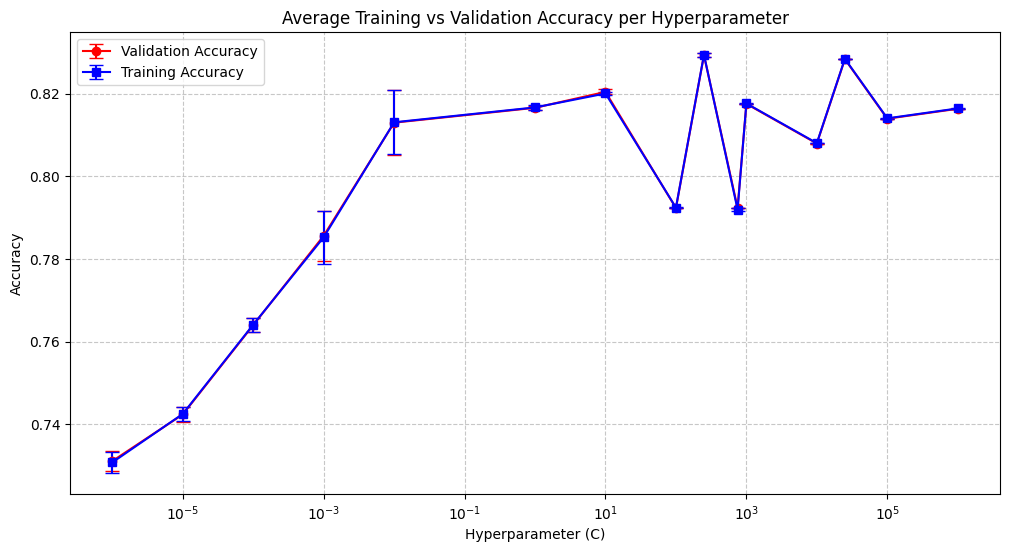

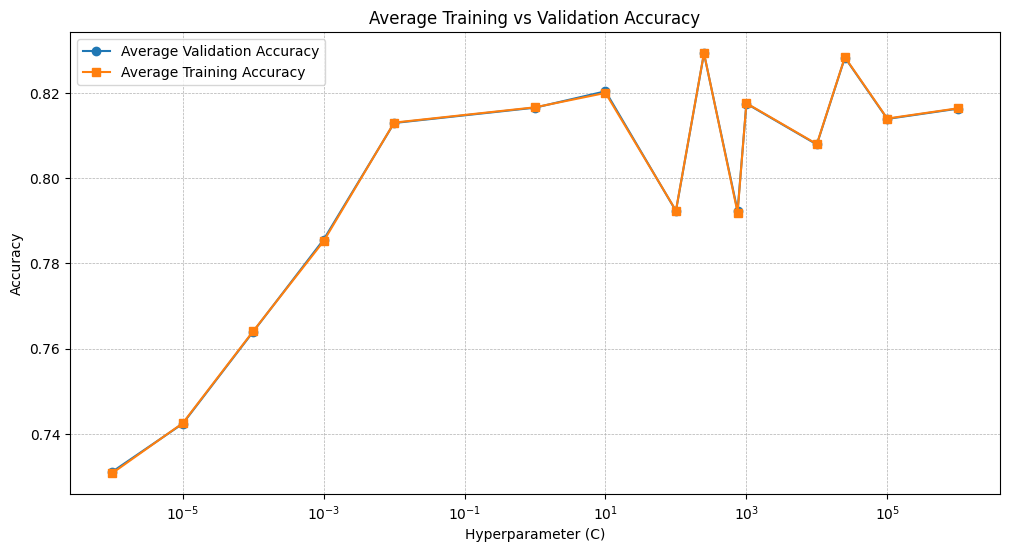

In [13]:
from lib.k_fold_cross_validation import KFoldIteratorInterface, KfoldCrossValidation
from lib.train import train_regularization_parameter


def spam_pipeline_k_fold_hyperparamter_tuning(C:list[int], K_sets:int) -> dict[str, dict[str, float]]:
    """
    Complete pipeline for loading, preprocessing, training, and evaluating spam models with different training sizes.
    Loads the Spam dataset, preprocesses the images, splits into training and validation sets, trains models, and prints error rates for each training size.
    """

    spam = load_spam()
    spam_training_data = spam["training_data"]
    spam_training_labels = spam["training_labels"]
    k_fold: KFoldIteratorInterface = KfoldCrossValidation(data=spam_training_data, labels=spam_training_labels, K=K_sets) 
    model_accuracy_per_C = {}
    for c in C:
        model_accuracy_per_C[c] = {"training_accuracy":[], "validation_accuracy" : []}
        while k_fold.has_next():
            split = k_fold.next()
            trained_model = train_regularization_parameter(split.x_train, split.y_train, c)
            training_res = trained_model.predict(split.x_train)
            training_accuracy =  classification_accuracy(training_res, split.y_train)
            # Validation
            validation_res = trained_model.predict(split.x_val)
            validation_accuracy =  classification_accuracy(validation_res, split.y_val)
            model_accuracy_per_C[c]["training_accuracy"].append(training_accuracy)
            model_accuracy_per_C[c]["validation_accuracy"].append(validation_accuracy)
            
        k_fold: KFoldIteratorInterface = KfoldCrossValidation(data=spam_training_data, labels=spam_training_labels, K=K_sets) 

    return model_accuracy_per_C
            


classification_accuracy_results: dict[int, dict[str, float]] =  spam_pipeline_k_fold_hyperparamter_tuning (
    [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1, 10, 100, 1000, 250, 750, 10000, 25000, 100000, 1e6],
    5)
plot_Box = []
v=[]
t=[]
hp=[]
for c, errors in classification_accuracy_results.items():
    v.append(errors["validation_accuracy"])
    t.append(errors["training_accuracy"])
    hp.append(c)
    
def lineplot(hp,v,t) -> None:
    hp, v, t = zip(*sorted(zip(hp, v, t), key=lambda x: x[0]))
    plt.figure(figsize=(12,6))
    plt.plot(hp, v, marker='o', label="Validation Accuracy")
    plt.plot(hp, t, marker='s', label="Training Accuracy")
    plt.xscale("log")   
    plt.xlabel("Hyperparameter (C)")
    plt.ylabel("Accuracy")
    plt.title("Training vs Validation Accuracy")
    plt.legend()
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.show()
    
    
def my_barplot(hp,v,t) -> None:
    avg_val = [np.mean(vv) for vv in v]
    std_val = [np.std(vv) for vv in v]
    avg_train = [np.mean(tt) for tt in t]
    std_train = [np.std(tt) for tt in t]
    sorted_hp, avg_val, std_val, avg_train, std_train = zip(*sorted(
        zip(hp, avg_val, std_val, avg_train, std_train), key=lambda x: x[0]
    ))
    plt.figure(figsize=(12,6))
    plt.errorbar(sorted_hp, avg_val, yerr=std_val, fmt='o-', color='red', label='Validation Accuracy', capsize=5)
    plt.errorbar(sorted_hp, avg_train, yerr=std_train, fmt='s-', color='blue', label='Training Accuracy', capsize=5)
    plt.xscale('log')
    plt.xlabel('Hyperparameter (C)')
    plt.ylabel('Accuracy')
    plt.title('Average Training vs Validation Accuracy per Hyperparameter')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()
    
    
    
def average_of_cross_validation() -> None:
    avg_validation = []
    avg_training = []
    hyperparams = []
    for c, errors in classification_accuracy_results.items():
        avg_val = np.average(errors["validation_accuracy"])
        avg_train = np.average(errors["training_accuracy"])
        hyperparams.append(c)
        avg_validation.append(avg_val)
        avg_training.append(avg_train)
    hyperparams, avg_validation, avg_training = zip(*sorted(
        zip(hyperparams, avg_validation, avg_training),
        key=lambda x: x[0]
    ))

    plt.figure(figsize=(12,6))
    plt.plot(hyperparams, avg_validation, marker='o', label="Average Validation Accuracy")
    plt.plot(hyperparams, avg_training, marker='s', label="Average Training Accuracy")
    plt.xscale("log")
    plt.xlabel("Hyperparameter (C)")
    plt.ylabel("Accuracy")
    plt.title("Average Training vs Validation Accuracy")
    plt.legend()
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.show()
    
lineplot(hp,v, t)
my_barplot(hp,v,t)
average_of_cross_validation()

# Speed Up Training

In [ ]:

mnist_data = load_mnist()
mnist_training_data = preprocess_image(mnist_data["training_data"])
mnist_training_labels = mnist_data["training_labels"]
subset_size = 5000
training_data, training_labels, validation_data, validation_labels = training_validation_split(
    subset_size, mnist_training_data, mnist_training_labels
)
test_hyperparameters = [0.001, 0.01, 1, 10, 100]
single_time, multi_time, _, _ = compare_single_vs_multi(
    training_data, training_labels, validation_data, validation_labels, test_hyperparameters
)
print(f"Single-process time: {single_time:.2f} seconds")
print(f"Multiprocessing time: {multi_time:.2f} seconds")

In [15]:
%pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.
